This notebook is a narrative exploration of efforts to predict the number of citations per year a paper will receive,
based on data available at time of publication.

A full exploration of 25 different prediction models can be found [here](askfhs)

In this notebook I look to predict the number of citations a paper will received based upon
* the words used in the abstract
* physics-inspired semantic metrics (implemented in github.com/zhafen/cc and employed in Imel & Hafen in prep)
* metadata (publishing journal, number of authors, number of pages, etc.)

The raw code for this analysis can be [found here](https://github.com/zhafen/work-sample).

I aimed to keep this work sample clean, so please reach out if you have questions about details I have not included.

You can jump to punchlines in the analysis via these links:

# User-Defined Parameters

This dictionary contains various user-defined parameters. They will be explained when they are utilized.

In [53]:
pm = dict(
    
    # Data selection
    data_dir = '/Users/zhafen/data/literature_topography',
    region_number = 8,
    convergence_degree = 3,
    kernel_size = 16,
    
    # Features
    numerical_variables = [
        'age',
        'converged_kernel_size',
        'density',
        'fringe_factor',
        'references_count',
        'page_count',
        'log_author_count',
    ],
    categorical_variables = [
        'journal_filtered',
    ],
    semantic_variables = [
        'density',
        'fringe_factor',
    ],
    
    # Modeling
    scoring = 'neg_root_mean_squared_error',
    
)

# Data

I use publication abstracts and metadata pulled from the [NASA astrophysics data sytem](https://ui.adsabs.harvard.edu) via [the official API](https://ui.adsabs.harvard.edu/help/api/). The analyzed publications are from a randomly-chosen physics or astrophysics specialization.

I externally preprocessed the abstract data with natural language processing (including tokenizing, stemming, and removing filler words), and each abstract has a corresponding bag-of-words representation.

## Load raw data

In [2]:
import numpy as np
import os

In [3]:
# My custom non-relational-data-management package
import verdict
# My library for NLP analysis of scientific abstracts
from cc import atlas, cartography, utils

In [4]:
# Load summary information.
# I analyzed several randomly chosen specializations ("regions"), of which we are choosing an arbitrary one.
summary_data_fp = os.path.join( pm['data_dir'], 'regions', 'regions_summary.h5' )
data = verdict.Dict.from_hdf5( summary_data_fp )
data_k = data['regions'][str(pm['region_number'])]

In [5]:
# Class for management of abstracts
atlas_dir = os.path.join( pm['data_dir'], 'regions', 'region_{}'.format( pm['region_number'] ) )
a = atlas.Atlas( atlas_dir, load_bibtex=False )

Loading saved atlas data.


0it [00:00, ?it/s]
100%|█████████████████████████████████| 37311/37311 [00:01<00:00, 22580.20it/s]


In [6]:
# Class for analysis of vectorized abstracts
projection = a.vectorize(
    verbose = True,
)
c = cartography.Cartographer( **projection )

Vectorizing text...
Using saved vectorized text...


In [7]:
# Retrieve metrics I calculated in external pre-processing
metrics_fp = os.path.join( atlas_dir, 'topography_metrics.h5' )
metrics = verdict.Dict.from_hdf5( metrics_fp )

In [8]:
# Not all the publications are viable for analysis.
# I've saved information about what publications are viable, and here we load the identifying information.
converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
converged = converged_kernel_size >= pm['kernel_size']
publications = c.publications[converged]
inds = np.arange( c.publications.size )[converged]

In [9]:
# Select word vectors
v = c.vectors[inds]

## Format into a DataFrame

In [10]:
import copy
import pandas as pd
import warnings

In [11]:
# Make into a dataframe, for convenience.
df_data = copy.deepcopy( metrics )
df_data['projection_ind'] = inds
df = pd.DataFrame(
    data = df_data._storage,
    index=publications,
)

In [12]:
# Drop publications with no citations.
# This catches all grant submissions, etc.
df = df.loc[np.invert( np.isclose( df['citations_per_year'], 0. ) )]

In [13]:
# Add logscale versions for some variables
for column in [ 'density', 'citations_per_year', ]:
    df['log_{}'.format( column )] = np.log10( df[column] )

## Derive or retrieve additional quantities

In [14]:
import tqdm

### ADS metadata

In [15]:
citation_keys = []
additional_data = {
    'references_count': [],
    'pages': [],
    'author': [],
    'journal': [],
    'title': [],
    'abstract_character_count': [],
    'entry_date': [],
}
for citation_key, p in tqdm.tqdm( a.data.items() ):
    
    citation_keys.append( citation_key )
    
    # number of references
    if p.references is None:
        additional_data['references_count'].append( 0 )
    else:
        additional_data['references_count'].append( len( p.references ) )
    
    # Citation info
    for key in [ 'pages', 'author', 'journal', 'title' ]:
        try:
            additional_data[key].append( p.citation[key] )
        except KeyError:
            additional_data[key].append( pd.NA )
            
    # Abstract
    additional_data['abstract_character_count'].append( len( p.abstract_str() ) )
    
    # Entry date
    additional_data['entry_date'].append( p.entry_date )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37311/37311 [00:02<00:00, 16398.38it/s]


In [16]:
# Convert to datetime
additional_data['entry_date'] = pd.to_datetime( additional_data['entry_date'] )

In [17]:
# Join it onto the existing dataframe
additional_df = pd.DataFrame( data=additional_data, index=citation_keys )
df = df.join( additional_df )

### Index

In [18]:
df['ind'] = np.arange( df.index.size )

### Page count

In [19]:
# Setup data structurs
df['page_count'] = np.full( len( df ), np.nan )

In [20]:
# Get rid of the "L" in front of the pages for publications submitted to letters.
pages_str = df['pages'].str.replace( 'L|P', '' )

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_3193/1933168570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pages_str = df['pages'].str.replace( 'L|P', '' )


In [21]:
# Split into two to take the difference
pages_split = pages_str.str.split( '-', expand=True )

In [22]:
# Identify the parseable data
is_not_none = np.invert( pages_split[1].isnull() )
is_numeric = pages_split[1].str.isnumeric()
is_page_range = is_not_none & is_numeric

In [23]:
# For the valid page ranges, set the page count
df.loc[is_page_range,'page_count'] = (
    pages_split[1].loc[is_page_range].astype( int )
    - pages_split[0].loc[is_page_range].astype( int )
)

In [24]:
# There can be one or two edge cases where there's a negative page count because of the formatting
df.loc[df['page_count']<0,'page_count'] = np.nan

### Author count

In [25]:
df['author_count'] = df['author'].str.split( ' and ' ).apply( len )
df['log_author_count'] = df['author_count'].apply( np.log10 )

### Title character count

In [26]:
df['title_character_count'] = df['title'].str.len()

### Journals, filtered

In [27]:
# Find the most common journals
df_grouped = df.groupby( 'journal' )
journal_entry_count = df_grouped.size().sort_values( ascending=False )
most_common_journals = journal_entry_count.iloc[:5].index

In [28]:
most_common_journals

Index(['\apj', '\mnras', '\aap', '\aj', '\apjl'], dtype='object', name='journal')

In [29]:
# Make a new column accordingly
df['journal_filtered'] = df['journal'].copy()
is_not_common_journal = np.invert( df['journal'].isin( most_common_journals ) )
df.loc[is_not_common_journal,'journal_filtered'] = 'other'
df.loc[df['journal'].isna(),'journal_filtered'] = 'other'

### Word vectors

In [30]:
v = c.vectors[df['projection_ind']]

## Summarize data

There are two main data containers:
`df`, which contains all the metadata and derived quantities,
and `v`, which contains the word vectors.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7380 entries, 2004JMOp...51.1447V to 1972ApJ...175L..73S
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   age                        7380 non-null   float64            
 1   citations_per_year         7380 non-null   float64            
 2   converged_kernel_size      7380 non-null   int32              
 3   density                    7359 non-null   float64            
 4   fringe_factor              7359 non-null   float64            
 5   kernel_constant_asymmetry  7359 non-null   float64            
 6   smoothing_length           7359 non-null   float64            
 7   projection_ind             7380 non-null   int64              
 8   log_density                7359 non-null   float64            
 9   log_citations_per_year     7380 non-null   float64            
 10  references_count           7380 non-null   i

In [32]:
df.head()

,age,citations_per_year,converged_kernel_size,density,fringe_factor,kernel_constant_asymmetry,smoothing_length,projection_ind,log_density,log_citations_per_year,...,journal,title,abstract_character_count,entry_date,ind,page_count,author_count,log_author_count,title_character_count,journal_filtered
2004JMOp...51.1447V,18.033916,2.495301,22,13.197566,0.679266,10.868260,1.212345,2,1.120494,0.397123,...,Journal of Modern Optics,{Ultrafast superconducting single-photon detec...,1173,2005-05-11 00:00:00+00:00,0,11.0,13,1.113943,103,other
2002MNRAS.336.1129B,20.556883,1.070202,57,13.189905,0.694470,11.111526,1.213049,3,1.120242,0.029466,...,\mnras,{STJ observations of the eclipsing polar HU Aqr},1063,2002-11-02 00:00:00+00:00,1,9.0,9,0.954243,48,\mnras
2002OptEn..41.1170V,20.855476,0.671287,56,13.394224,0.696136,11.138178,1.194545,4,1.126918,-0.173092,...,Optical Engineering,{Superconducting tunnel junctions as photon-co...,1532,2002-07-16 00:00:00+00:00,2,14.0,5,0.698970,110,other
2001MNRAS.324..899P,21.784125,1.606676,23,13.020577,0.660474,10.567585,1.228824,5,1.114630,0.205928,...,\mnras,{High-speed energy-resolved STJ photometry of ...,1523,2001-08-11 00:00:00+00:00,3,10.0,7,0.845098,74,\mnras
1999MNRAS.309..379W,23.531848,1.614834,79,13.100298,0.671835,10.749364,1.221346,7,1.117281,0.208128,...,\mnras,{The seeing at the William Herschel Telescope},512,1999-11-12 00:00:00+00:00,4,8.0,4,0.602060,46,\mnras


In [33]:
v.shape

(7380, 30286)

## Split testing and training data

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Split dataframe
df_train, df_test = train_test_split( df, test_size=0.2, random_state=42 )

In [36]:
# Split input
X_train = df_train[pm['numerical_variables'] + pm['categorical_variables']].values
X_test = df_test[pm['numerical_variables'] + pm['categorical_variables']].values

In [37]:
# Split word vector input
v_train = v[df_train['ind']]
v_test = v[df_test['ind']]

In [38]:
# Split output
y_train = df_train['log_citations_per_year'].values
y_test = df_test['log_citations_per_year'].values

In [39]:
# Split semantic input
M_train = df_train[pm['semantic_variables']].values
M_test = df_test[pm['semantic_variables']].values

# Exploratory Data Analysis

I've explored this dataset thoroughly elsewhere, so here I'll just visually summarize the dataset.

In [166]:
import seaborn as sns

sns.set_style( 'whitegrid' )

## Citations per year

<AxesSubplot: xlabel='log_citations_per_year', ylabel='Count'>

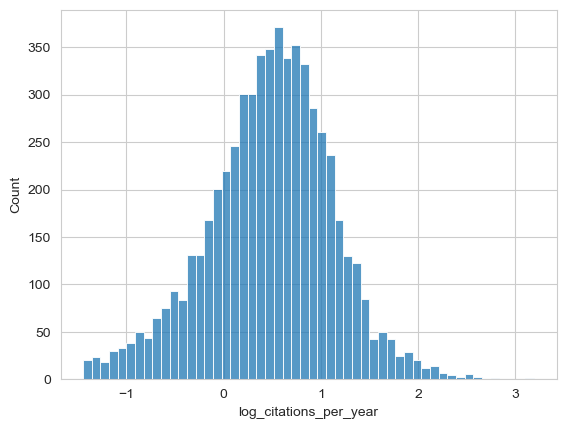

In [41]:
sns.histplot(
    df_train,
    x = 'log_citations_per_year',
)

## Numerical variables

(0.0, 40.0)

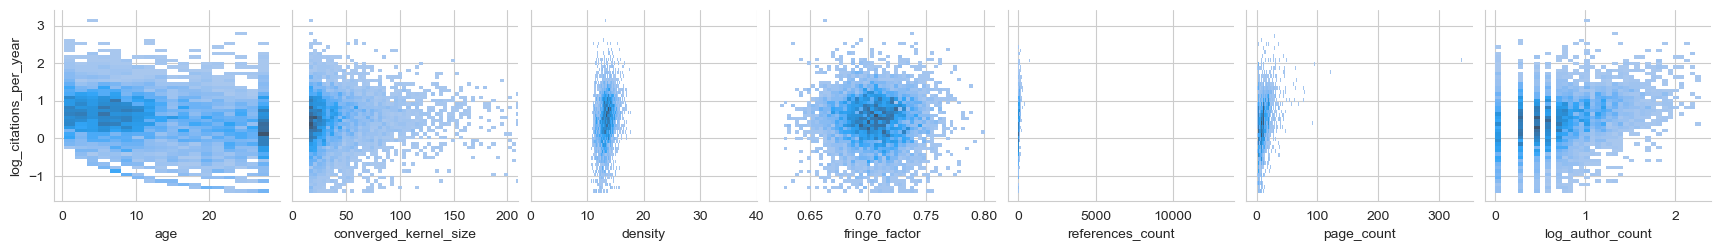

In [42]:
pairplot = sns.pairplot(
    df_train,
    x_vars = pm['numerical_variables'],
    y_vars = [ 'log_citations_per_year',],
    kind = 'hist',
    # plot_kws = { 'line_kws': { 'color': 'k', }, },
)
pairplot.axes[0,1].set_xlim( 0, 210 )
pairplot.axes[0,2].set_xlim( 0, 40 )

## Categorical variable

<AxesSubplot: xlabel='journal_filtered', ylabel='log_citations_per_year'>

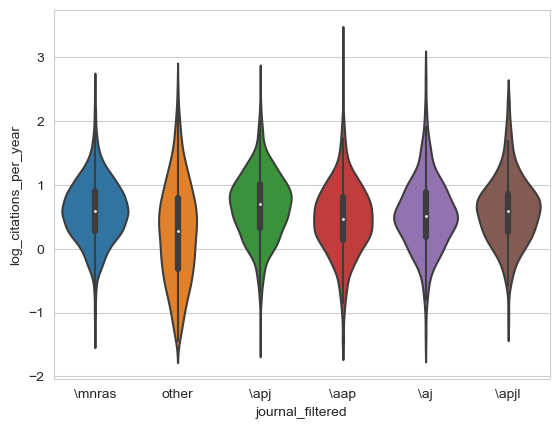

In [43]:
sns.violinplot(
    df_train,
    x = 'journal_filtered',
    y = 'log_citations_per_year',
)

# Modelling

## Preprocessing

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, KFold

In [45]:
# Two things for our numerical variables:
# Imputation of missing values and scaling by mean and std
numerical_preprocessing = Pipeline(
    [
        ( 'impute', SimpleImputer( strategy='mean' ) ),
        ( 'scale', StandardScaler() ),
    ]
)

In [46]:
# Combine the numerical preprocessing with onehot encoding for the categorical variable
preprocessing = ColumnTransformer( [
        ( 'numerical', numerical_preprocessing, pm['numerical_variables'] ),
        ( 'onehot', OneHotEncoder(), pm['categorical_variables'] ),
] )

In [47]:
# Preprocessing for word vectors is just scaling
vector_preprocessing = Pipeline(
    [
        ( 'scale', Normalizer() ),
    ]
)

In [48]:
# There is a subset of the numerical variables that I refer to as "semantic".
# These variables contain metrics that measure the relationship of the words in a publication to words in other publications.
semantic_preprocessing = Pipeline(
    [
        ( 'scale', StandardScaler() ),
    ]
)

In [49]:
# Set up a kfold object for cross validation
kfold = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 1532
)

## Baseline

We use the mean log citations per year as the baseline.

In [51]:
from sklearn.base import BaseEstimator

In [120]:
class Baseline( BaseEstimator ):
    '''The baseline model is just the mean. We put it into a class
    for full consistency with all future models.'''
    
    def fit( self, X , y):
        
        self.estimate = y.mean()
        
    def predict( self, X ):
        
        return np.full( X.shape[0], self.estimate )

model = Baseline()

In [121]:
# Object for storing data
crossvals = {}

In [122]:
# Perform and store cross validation
crossvals['baseline'] = verdict.Dict( cross_validate(
    estimator = model,
    X = X_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

Because the baseline is the mean we expect the RMSE for the individual folds to be similar to the standard deviation of the full sample.

In [123]:
-crossvals['baseline']['test_score']

array([0.65022868, 0.61344922, 0.62270003, 0.67515721, 0.65758129])

In [124]:
sample_mean = y_train.mean()
sample_std = y_train.std()
sample_std

0.6441600924434792

## Simple Linear Regression

For our first model we'll see if we can just use linear least squares regression with the word vectors as input.
This is a pretty silly model: we're limited to linear order because of the high dimensionality of the word vectors, and it is unlikely that a single line can describe the citation relationship.

In [125]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [126]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'poly', PolynomialFeatures( degree=1 ) ),
        ( 'reg', LinearRegression( fit_intercept=False ) ),
    ]
)

In [127]:
# Perform and store cross validation
crossvals['linear_regression'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

In [128]:
import matplotlib
import matplotlib.pyplot as plt

In [150]:
def rmse_swarmplot( crossval, y_lim=(sample_std-0.5, sample_std+0.5) ):    
    
    # Format data
    df_data = -1. * verdict.Dict( crossvals ).inner_item( 'test_score' )
    crossval_df = pd.DataFrame( df_data._storage ).melt( var_name='model', value_name='rmse' )
    
    # Visualize
    fig = plt.figure( figsize=(len(df_data)*1.5, 3) )
    ax = plt.gca()
    
    # Plot itself
    sns.swarmplot(
        data = crossval_df,
        x = 'model',
        y = 'rmse',
        ax = ax,
    )
    
    # Mark the analytic baseline value for comparison
    ax.axhline(
        sample_std,
        color = '0.5',
        linestyle = '--',
        linewidth = 0.75,
    )

    ax.set_xlabel( 'model' )
    ax.set_ylabel( r'RMSE in log_citations_per_year' )
    
    ax.set_ylim( y_lim )
    
    return fig

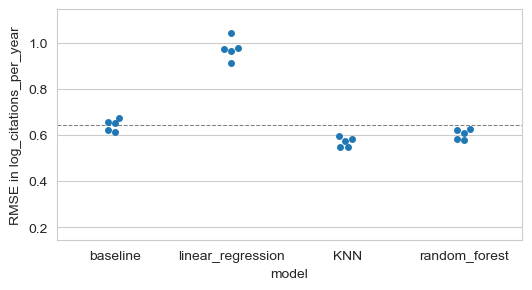

In [151]:
fig = rmse_swarmplot( crossvals )

No surprise, this model doesn't perform particularly well.

## Random Forest

For a more-sophisticated phenomenological description of the data, let's try a random forest.

In [141]:
from sklearn.ensemble import RandomForestRegressor

In [142]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', RandomForestRegressor( max_depth=3, n_estimators=200 ) ),    ]
)

In [143]:
# Perform and store cross validation
crossvals['random_forest'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

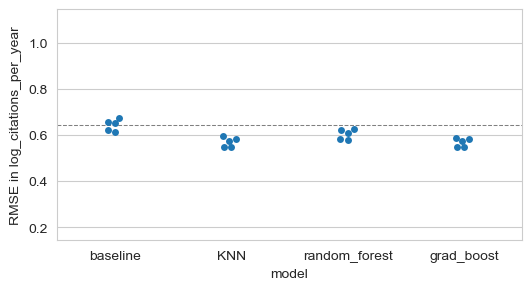

In [167]:
fig = rmse_swarmplot( crossvals )

Better performance than the baseline! We're getting somewhere.

## Gradient Boosting

If the random forest model went well, how about a gradient boosting model with decision trees as the base?

In [154]:
from sklearn.ensemble import GradientBoostingRegressor

In [155]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', GradientBoostingRegressor() ),
    ]
)

In [156]:
# Perform and store cross validation
crossvals['grad_boost'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

In [157]:
# Let's go ahead and drop the linear regression model so it's not distracting us.
del crossvals['linear_regression']

KeyError: 'linear_regression'

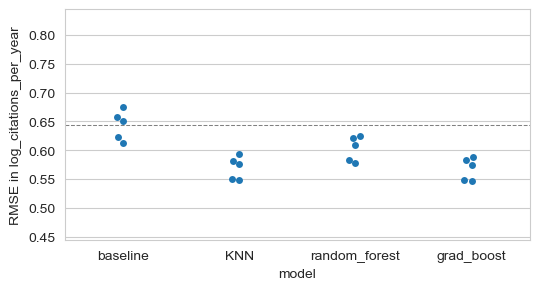

In [159]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.2, sample_std+0.2) )

Great. We have a model that does noticeably better than the baseline.

In [169]:
print( 'We can predict the number of citations to within a factor of ~{:.2g} on average.'.format( 10.**-crossvals['grad_boost']['test_score'].mean() ) )

We can predict the number of citations to within a factor of ~3.7 on average.


There is still a significant amount of error in the prediction: a factor of a few in predicting the number of citations per year. This is perhaps to be expected: it would be surprising if the main thing driving citation trends could be predicted simply via the words used, with no information about how those words relate to one another (e.g. via an N-gram language model).

## K Nearest Neighbors

So far we've been treating the word vectors as generic data. To further improve our model, and add some explanatory power, let's make use of our knowledge about what the vectors _are_: the language used in a scientific abstract.

Here's a simple hypothesis:
The number of citations a paper receives correlates with the number of citations papers on similar topics (i.e. using similar words) receive. Fortunately this is a simple, well-defined model: the K Nearest Neighbors model.

In [172]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [173]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'knn', KNeighborsRegressor( n_neighbors=32 ) ),
    ]
)

In [174]:
# Perform a parameter search for the number of neighbors to use
param_grid = {
    'knn__n_neighbors': [ 4, 16, 32, 64, 128, 256, ],
}
search = GridSearchCV( model, param_grid, )
search.fit( v_train, df_train['log_citations_per_year'] )
model = search.best_estimator_
search.best_params_

{'knn__n_neighbors': 16}

In [175]:
# Perform and store cross validation
crossvals['KNN'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

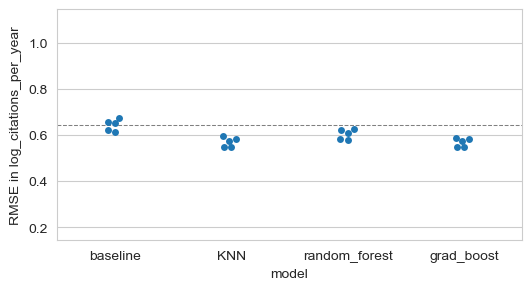

In [176]:
fig = rmse_swarmplot( crossvals )

KNN does comparably well to gradient boosting, but is much more interpretable!

## Explanatory Metrics: Density and Asymmetry

Related to K Nearest Neighbors, we can ask if the local geometry of the hyperspace is related to citations received. In particular, we'll define two metrics:

density, which tracks the number of similar papers,
$${\rm density} = \frac{{\rm kernel\,size\,(K)}}{{\rm distance\,to\,the\,farthest\,neighbor}}$$

and "fringe factor", which tracks if a paper uses language in a new direction relative to existing similar papers.
$${\rm fringe\,factor} = \frac1K \sum_i \frac{\vec v - \vec v_i}{|\vec v - \vec v_i|} $$
The concept of edginess comes from the concept of force balance.

<AxesSubplot: xlabel='density', ylabel='Count'>

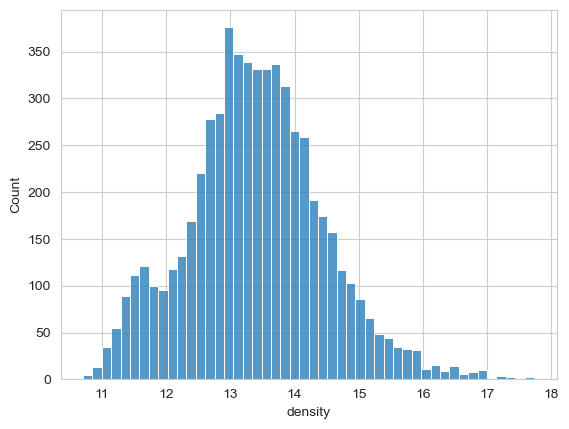

In [179]:
sns.histplot(
    df_train,
    x = 'density',
)

<AxesSubplot: xlabel='fringe_factor', ylabel='Count'>

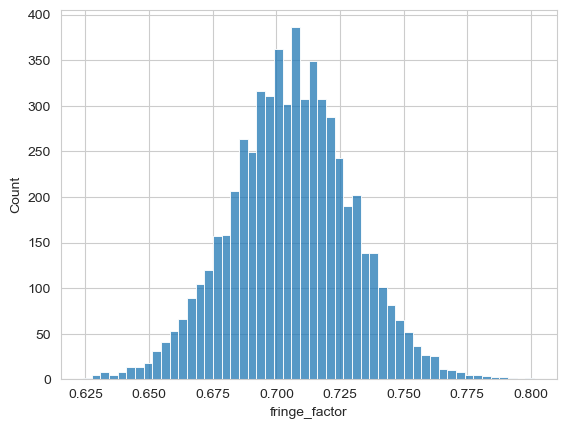

In [181]:
sns.histplot(
    df_train,
    x = 'fringe_factor',
)

As shown here, in preprocessing I calculated these quantities for this dataset.

Most of the meaningful modeling is in the calculation of these two quantities, so we'll fit a simple linear regression.

In [76]:
semantic_model = Pipeline(
    [
        ( 'preprocessing', semantic_preprocessing ),
        ( 'poly', PolynomialFeatures( degree=1 ) ),
        ( 'reg', LinearRegression( fit_intercept=False ) ),
    ]
)

In [ ]:
# This model uses different input data, and correspondingly let's keep it separate.
crossvals_semantic = {}

In [175]:
# Perform and store cross validation
crossvals_semantic['linear_regression'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

# Takeaways

* Even the best model can't predict citations that well. Our minimum RMSE suggests we will routinely misestimate by a factor of X

# Credits

Utilized python packages include:
* [ads](https://github.com/andycasey/ads)
* nltk